In [1]:
# Verifique a Disponibilidade da GPU:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15550530109852728669
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10520037787443794781
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3036833383
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1906915866568098373
physical_device_desc: "device: 0, name: NVIDIA RTX A1000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4623204522890528897
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
#Configuração do TensorFlow para GPU:

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
#Uso de Mixed Precision:

from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX A1000 Laptop GPU, compute capability 8.6


# EDSR

In [36]:
import os
import matplotlib.pyplot as plt

from skimage.util import view_as_windows
import numpy as np
import tifffile as tif

from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer
from tensorflow.python.data.experimental import AUTOTUNE

%matplotlib inline

In [5]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 2

# Downgrade operator
downgrade = None

In [6]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Importar Imagens

In [7]:
def data_augmentation_grayscale(input_image, patch_size, step_size):
    all_patches = []

    # Extract patches using view_as_windows
    patches = view_as_windows(input_image, (patch_size, patch_size), step=step_size)

    # Flatten the patches array
    patches = patches.reshape(-1, patch_size, patch_size)

    # Perform data augmentation here if needed
    # You can apply transformations like rotation, flipping, etc.
    rot90 = np.rot90(patches, axes=(1, 2))
    rot180 = np.rot90(patches, 2, axes=(1, 2))
    rot270 = np.rot90(patches, 3, axes=(1, 2))
    rot_patches = np.concatenate((rot90, rot180, rot270), axis=0)

    hor_flip = np.flip(patches, axis=1)
    ver_flip = np.flip(patches, axis=2)

    all_patches = np.concatenate((patches, rot_patches, hor_flip, ver_flip), axis=0)

    return all_patches

def import_and_augment_images(paste, patch_size, step_size):
    all_patches = []

    # Get the list of image files in the paste_path directory and sort them
    image_files = sorted([os.path.join(paste, file) for file in os.listdir(paste) if file.endswith('.tif')])

    # for every image file in the paste_path directory, import it, augment it, and return the concatenated patches
    for image_path in image_files:
        image = tif.imread(image_path)
        patches = data_augmentation_grayscale(image, patch_size, step_size)
        all_patches.append(patches)

    paste_image_patches = np.concatenate(all_patches, axis=0)
    return paste_image_patches

from PIL import Image
def import_and_augment_images_png(paste, patch_size, step_size):
    all_patches = []

    # Get the list of image files in the paste_path directory and sort them
    image_files = sorted([os.path.join(paste, file) for file in os.listdir(paste) if file.endswith('.png')])

    # for every image file in the paste_path directory, import it, augment it, and return the concatenated patches
    for image_path in image_files:
        # Importing PNG image using Pillow (PIL)
        image = np.array(Image.open(image_path))
        patches = data_augmentation_grayscale(image, patch_size, step_size)
        all_patches.append(patches)

    paste_image_patches = np.concatenate(all_patches, axis=0)
    return paste_image_patches

In [8]:
lr_paste = 'C:\\Users\\bielm\\Documents\\Mestrado\\0_SuperResolucao\\Dados_SR\\PNG_LR\\'
hr_paste = 'C:\\Users\\bielm\\Documents\\Mestrado\\0_SuperResolucao\\Dados_SR\\PNG_MR\\'

aug_LR = import_and_augment_images_png(lr_paste, patch_size=128, step_size=64)
aug_HR = import_and_augment_images_png(hr_paste, patch_size=256, step_size=128)

# make this one channel datasets into 3 channel datasets
aug_LR_stacked = np.stack((aug_LR,)*3, axis=-1)
aug_HR_stacked = np.stack((aug_HR,)*3, axis=-1)

In [9]:
aug_LR.shape, aug_HR.shape, aug_LR_stacked.shape, aug_HR_stacked.shape,

((34860, 128, 128),
 (34860, 256, 256),
 (34860, 128, 128, 3),
 (34860, 256, 256, 3))

3089


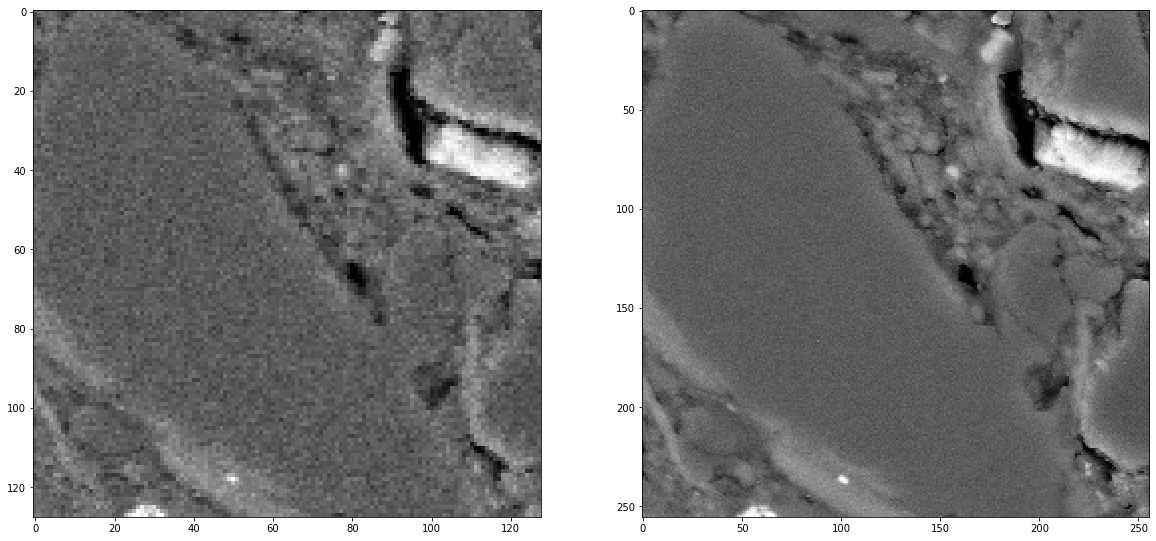

In [18]:
# use matplotlib para visualizar par de imagens lado a lado escolhidos aleatoriamente
import random

# crie um numero aleatorio
random_number = random.randint(0, aug_LR.shape[0])
print(random_number)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(aug_LR[random_number], cmap='gray')
ax[1].imshow(aug_HR[random_number], cmap='gray')
plt.show()


In [28]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# split
lr_train, lr_val, hr_train, hr_val = train_test_split(aug_LR, aug_HR, test_size=0.2, random_state=42)

# Convert lr_train and hr_train into tf.data.Dataset objects
lr_train_ds = tf.data.Dataset.from_tensor_slices(lr_train)
hr_train_ds = tf.data.Dataset.from_tensor_slices(hr_train)
hr_val_ds = tf.data.Dataset.from_tensor_slices(hr_val)
lr_val_ds = tf.data.Dataset.from_tensor_slices(lr_val)

# ds = tf.data.Dataset.zip((self.lr_dataset(), self.hr_dataset()))
train_ds = tf.data.Dataset.zip((lr_train_ds, hr_train_ds))
train_ds = train_ds.batch(16)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = tf.data.Dataset.zip((lr_val_ds, hr_val_ds))
valid_ds = valid_ds.batch(1)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)



In [29]:
train_dataset = train_ds
valid_dataset = valid_ds


In [30]:
# Função para adicionar dimensão ao final dos tensores
def add_channel_dimension(features, labels):
    features = tf.expand_dims(features, axis=-1)
    labels = tf.expand_dims(labels, axis=-1)
    return features, labels

# Modificando o pipeline para incluir a função add_channel_dimension
train_dataset = train_dataset.map(add_channel_dimension)
valid_dataset = valid_dataset.map(add_channel_dimension)



In [31]:
train_ds.element_spec, valid_ds.element_spec, train_dataset.element_spec, valid_dataset.element_spec    

((TensorSpec(shape=(None, 128, 128), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 256, 256), dtype=tf.uint8, name=None)),
 (TensorSpec(shape=(None, 128, 128), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 256, 256), dtype=tf.uint8, name=None)),
 (TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None)),
 (TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None)))

In [21]:
lr_train.shape, hr_train.shape, lr_val.shape, hr_val.shape

((27888, 128, 128, 3),
 (27888, 256, 256, 3),
 (6972, 128, 128, 3),
 (6972, 256, 256, 3))

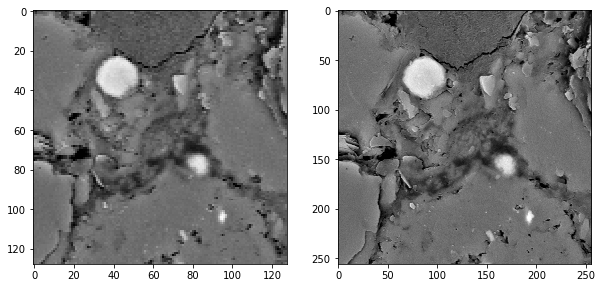

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(lr_val[2100])
axs[1].imshow(hr_val[2100])
plt.show()

In [33]:
train_dataset.element_spec, valid_dataset.element_spec

((TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None)),
 (TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None)))

## Tentativas erradas

In [13]:
import glob

In [14]:
lr_images_path = r'C:\\Users\\bielm\\Documents\\Mestrado\\0_SuperResolucao\\Dados_SR\\PNG_LR\\'
hr_images_path = r'C:\\Users\\bielm\\Documents\\Mestrado\\0_SuperResolucao\\Dados_SR\\PNG_MR\\'

file_paths_1 = sorted(sorted(glob.glob(os.path.join(lr_images_path, ".png"))))
file_paths_2 = sorted(sorted(glob.glob(os.path.join(hr_images_path, ".png"))))

lr_dataset = tf.data.Dataset.from_tensor_slices(file_paths_1)
hr_dataset = tf.data.Dataset.from_tensor_slices(file_paths_2)

def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image

In [15]:
lr_dataset = lr_dataset.map(load_and_preprocess_image)
hr_dataset = hr_dataset.map(load_and_preprocess_image)

TypeError: in user code:

    <ipython-input-14-0bf678e00e3c>:11 load_and_preprocess_image  *
        image = tf.io.read_file(file_path)
    c:\Users\bielm\anaconda3\envs\sisr\lib\site-packages\tensorflow\python\ops\gen_io_ops.py:575 read_file  **
        "ReadFile", filename=filename, name=name)
    c:\Users\bielm\anaconda3\envs\sisr\lib\site-packages\tensorflow\python\framework\op_def_library.py:493 _apply_op_helper
        (prefix, dtypes.as_dtype(input_arg.type).name))

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [10]:
def random_crop(lr_img, hr_img, hr_crop_size=256, scale=2):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)



In [19]:
def dataset(lr_dataset, hr_dataset, batch_size=16, repeat_count=None, random_transform=True, training=True):
    # Combine the low-resolution dataset and the high-resolution dataset
    ds = tf.data.Dataset.zip(lr_dataset, hr_dataset)
    
    # Apply random transformations to the image pairs if random_transform is True
    if random_transform:
        ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=scale), num_parallel_calls=AUTOTUNE)
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
    
    # Batch the dataset
    ds = ds.batch(batch_size)
    
    # Repeat the dataset for repeat_count times
    ds = ds.repeat(repeat_count)
    
    # Prefetch the dataset for faster processing
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    DATASET_SIZE= len(ds)

    train_size = int(0.9 * DATASET_SIZE)
    test_size = DATASET_SIZE - train_size

    train_dataset = ds.take(train_size)
    test_dataset = ds.skip(train_size)

    if training:
        return train_dataset
    else:
        return test_dataset

In [13]:
train_ds = dataset(lr_dataset, hr_dataset, batch_size=16, repeat_count=None, random_transform=True#, training=True)
valid_ds = dataset(lr_dataset, hr_dataset, batch_size=1, repeat_count=None, random_transform=False)#, training=False)

TypeError: zip() takes 1 positional argument but 2 were given

In [ ]:

batched_dataset = combined_dataset.batch(1)

prefetched_dataset = batched_dataset.prefetch(tf.data.experimental.AUTOTUNE)

DATASET_SIZE= len(prefetched_dataset)

train_size = int(0.9 * DATASET_SIZE)
test_size = DATASET_SIZE - train_size

train_dataset = prefetched_dataset.take(train_size)
test_dataset = prefetched_dataset.skip(train_size)

In [43]:
train_dataset.element_spec, test_dataset.element_spec

((TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None)))

Dataset

In [10]:
from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer

In [11]:
div2k_train = DIV2K(scale=scale, subset='train')
div2k_valid = DIV2K(scale=scale, subset='valid')

In [21]:
type(div2k_train)

data.DIV2K

In [13]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

Caching decoded images in C:\Users\bielm\Documents\Mestrado\0_SuperResolucao\super-resolution\super-resolution\cache\train_LR.cache ...


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe3 in position 134: invalid continuation byte

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-edsr-16-x4.tar.gz](https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/edsr-16-x4` directory containing the weights of the pre-trained model.

In [34]:
trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=depth),
                      checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}')

In [38]:
train_dataset.element_spec, valid_dataset.element_spec

((TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None)),
 (TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None),
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None)))

In [37]:
import time

# Measure time before the code
start_time = time.time()

# Train EDSR model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_dataset,
              valid_dataset,
              steps=300000,
              evaluate_every=1000,
              save_best_only=True)

# Measure time after the code
end_time = time.time()

# Calculate the elapsed time in minutes
elapsed_time = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time} minutes")

ValueError: Shapes (256, 256, 1) and (256, 256, 3) are incompatible

In [18]:
# Restore from checkpoint with highest PSNR
trainer.restore()

Model restored from checkpoint at step 1000.


In [19]:
# Evaluate model on full validation set
psnrv = trainer.evaluate(valid_ds)
print(f'PSNR = {psnrv.numpy():3f}')
#print(f'SSIM = {ssim.numpy():3f}')

PSNR = 3.858137


In [20]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Demo

In [ ]:
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [ ]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

In [ ]:
from PIL import Image
def display_images(lr_or_array):
    if isinstance(lr_or_array, str):
        lr = Image.open(lr_or_array)
    elif isinstance(lr_or_array, np.ndarray):
        lr = Image.fromarray(lr_or_array)
    else:
        raise ValueError("Invalid input type. Expected string (path) or numpy array.")

    sr = resolve_single(model, lr)

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(lr)
    ax[0].set_title('LR')
    ax[1].imshow(sr)
    ax[1].set_title('SR')
    plt.show()


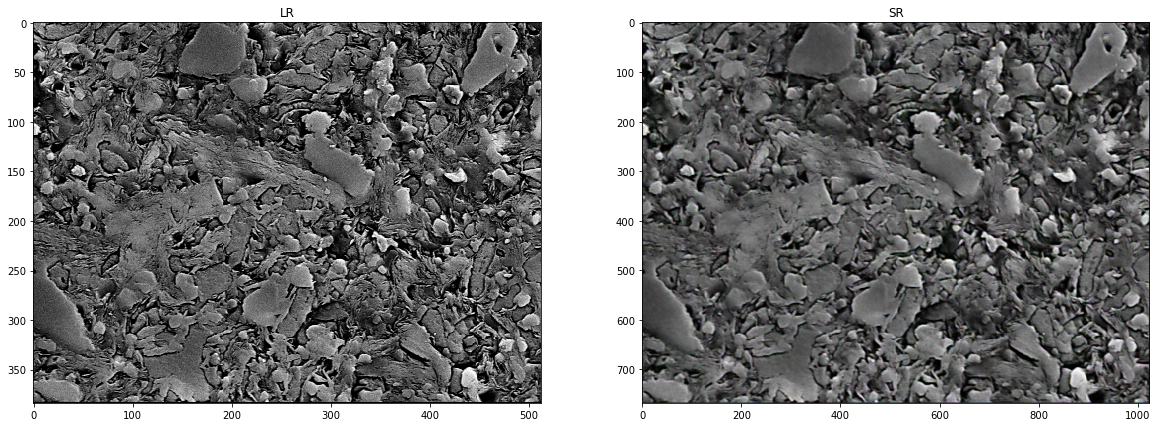

In [ ]:
path = r'C:\Users\bielm\Documents\Mestrado\Nova pasta\0_SuperResolucao\Dados_SR\1xLR\080_A3_LR.tif'
display_images(path)

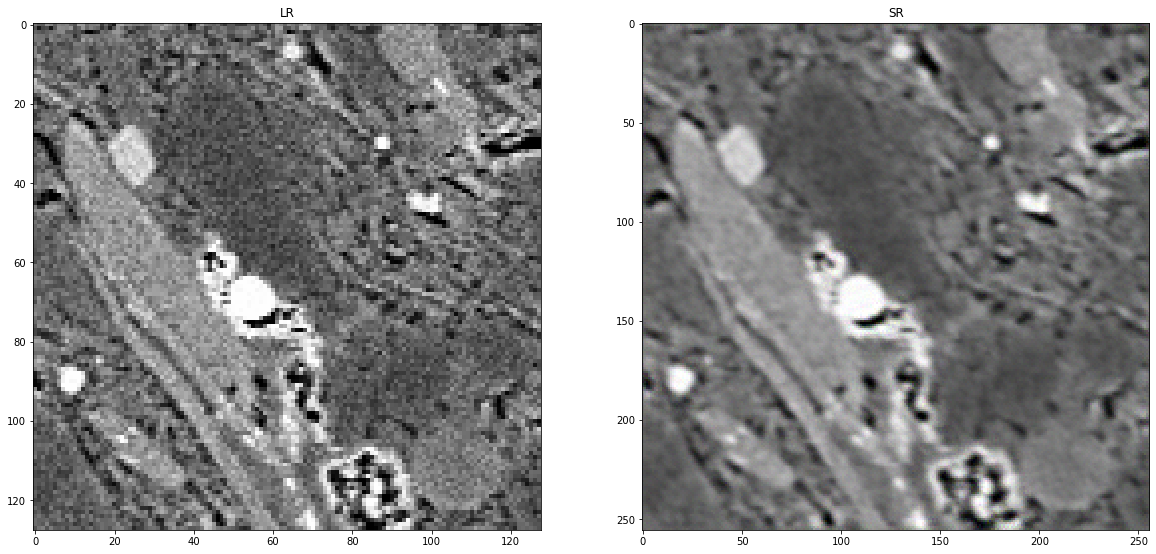

In [ ]:
display_images(lr_val[40])

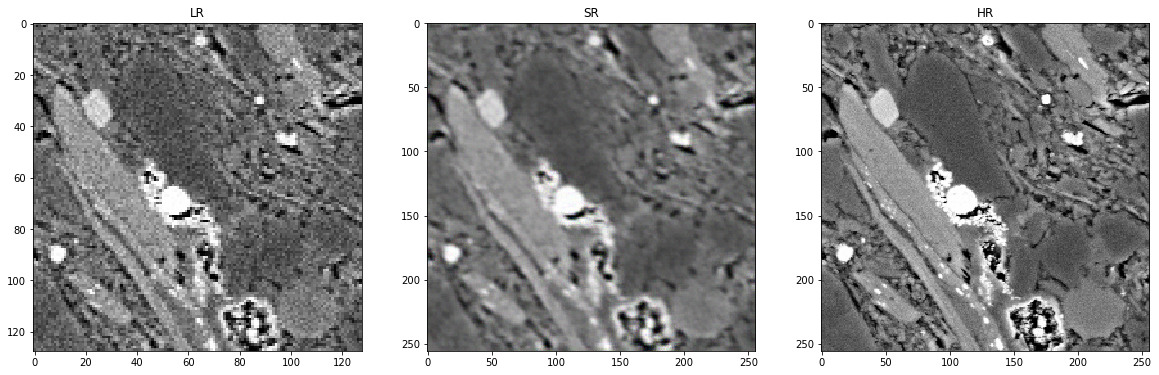

In [ ]:
def display_images(lr_array, new_array):
    lr = Image.fromarray(lr_array)
    new_img = Image.fromarray(new_array)
    sr = resolve_single(model, lr)
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(lr)
    ax[0].set_title('LR')
    ax[1].imshow(sr)
    ax[1].set_title('SR')
    ax[2].imshow(new_img)
    ax[2].set_title('HR')
    plt.show()

display_images(lr_val[40], hr_val[40])

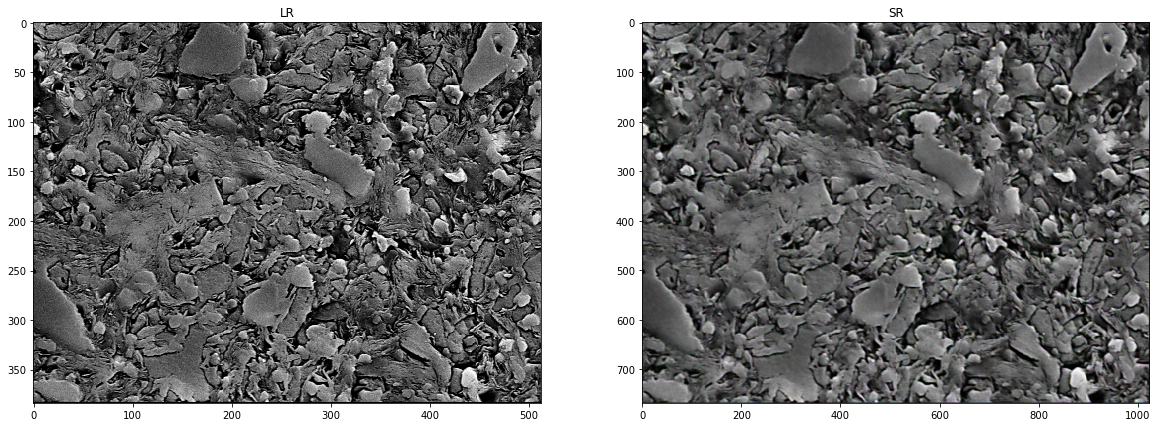

In [ ]:
from PIL import Image
path = r'C:\Users\bielm\Documents\Mestrado\Nova pasta\0_SuperResolucao\Dados_SR\1xLR\080_A3_LR.tif'
lr = Image.open(path)
sr = resolve_single(model, lr)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(lr)
ax[0].set_title('LR')
ax[1].imshow(sr)
ax[1].set_title('SR')
plt.show()

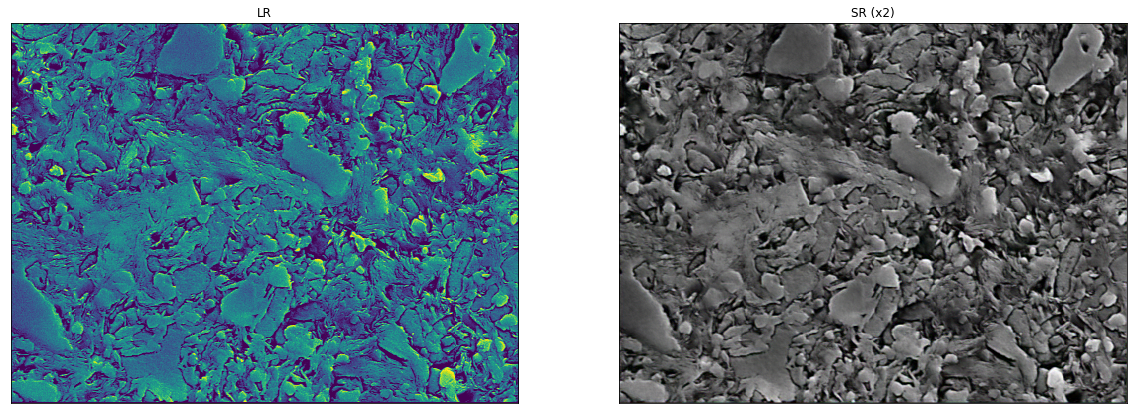

In [ ]:
resolve_and_plot(r'C:\Users\bielm\Documents\Mestrado\Nova pasta\0_SuperResolucao\Dados_SR\1xLR\080_A3_LR.tif')


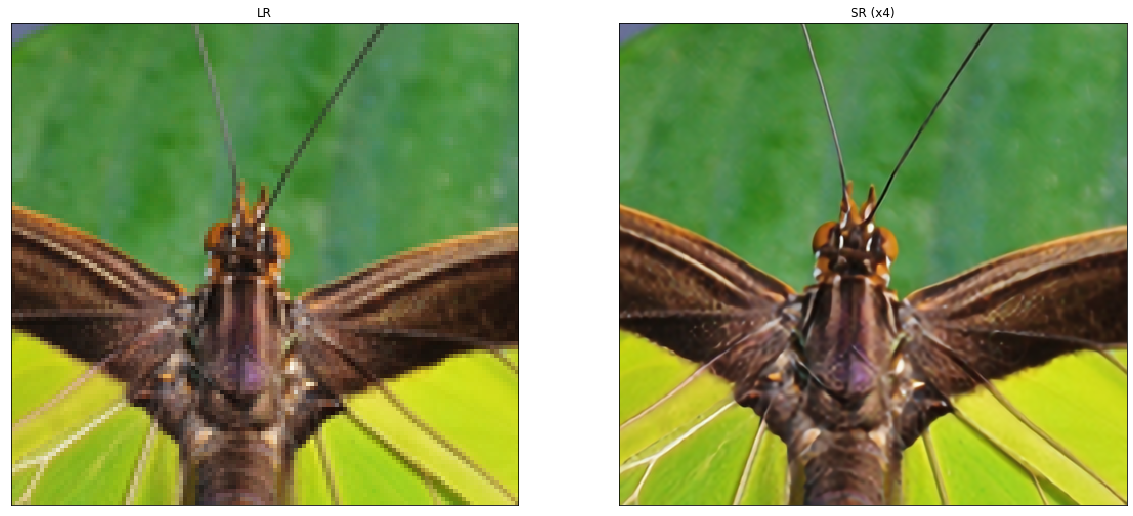

In [ ]:
resolve_and_plot('demo/0829x4-crop.png')

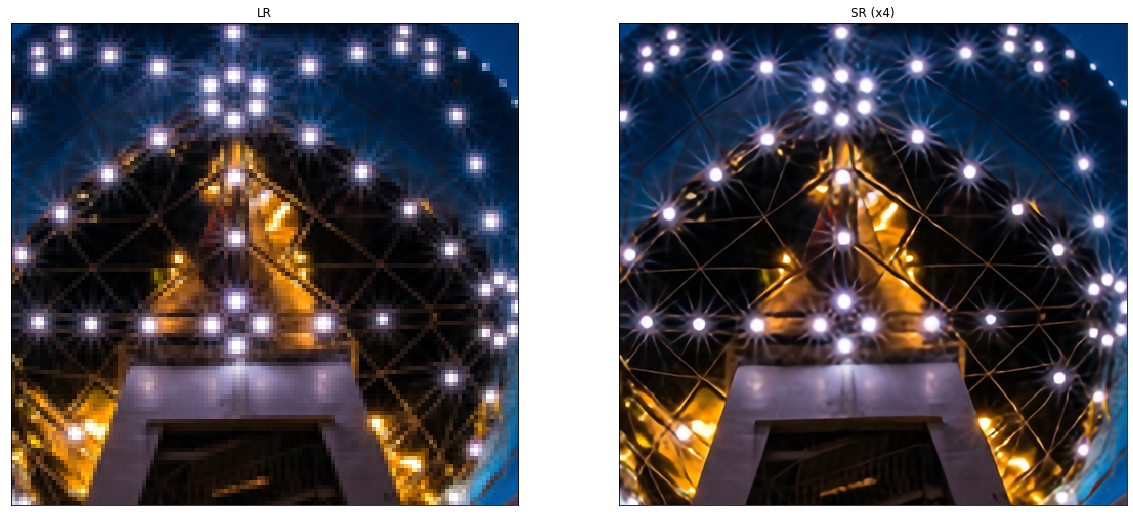

In [ ]:
resolve_and_plot('demo/0851x4-crop.png')